# Brain Tumor Classification - ViT vs CNNs

### What are Brain Tumors?

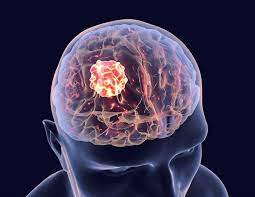

A brain tumor is an abnormal growth of cells within the brain or surrounding tissues. Brain tumors can be either benign (non-cancerous) or malignant (cancerous), and they can occur at any age.

Benign brain tumors grow slowly, have clear borders and do not spread to other parts of the body. However, even a benign brain tumor can cause serious health problems if it grows in a critical area of the brain or becomes too large.

Malignant brain tumors, on the other hand, grow quickly and can invade nearby healthy brain tissue. They can also spread to other parts of the brain or to other parts of the body through the bloodstream or lymphatic system. Malignant brain tumors are generally more serious and may require aggressive treatment, including surgery, radiation therapy, and chemotherapy.

### What are CNNs?
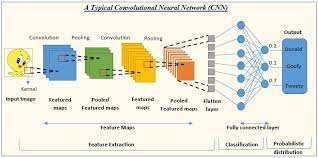

CNN stands for Convolutional Neural Network, which is a type of deep learning algorithm commonly used for image and video processing tasks. CNNs are designed to automatically learn and extract relevant features from input images and classify them into different categories.

The basic architecture of a CNN consists of several layers, including convolutional layers, pooling layers, and fully connected layers. In the convolutional layer, a set of learnable filters are applied to the input image to produce a feature map, which captures the presence of specific features such as edges, lines, and textures. The pooling layer then reduces the spatial size of the feature map by down-sampling, which helps to reduce the computational cost and prevent overfitting.

The output of the pooling layer is fed into the fully connected layer, which performs the classification task. The fully connected layer consists of several neurons, each representing a different class label, and uses a softmax function to compute the probabilities of each class.

During the training phase, the weights of the filters in the convolutional layers and the neurons in the fully connected layers are optimized through a process called backpropagation, which involves computing the gradient of the loss function with respect to the weights and updating them using an optimization algorithm such as stochastic gradient descent (SGD).

CNNs have achieved state-of-the-art performance in many computer vision tasks, such as image classification, object detection, and semantic segmentation. They are widely used in various applications, such as autonomous driving, medical imaging, and facial recognition.

### What is a ViT (Vision Transformer)?
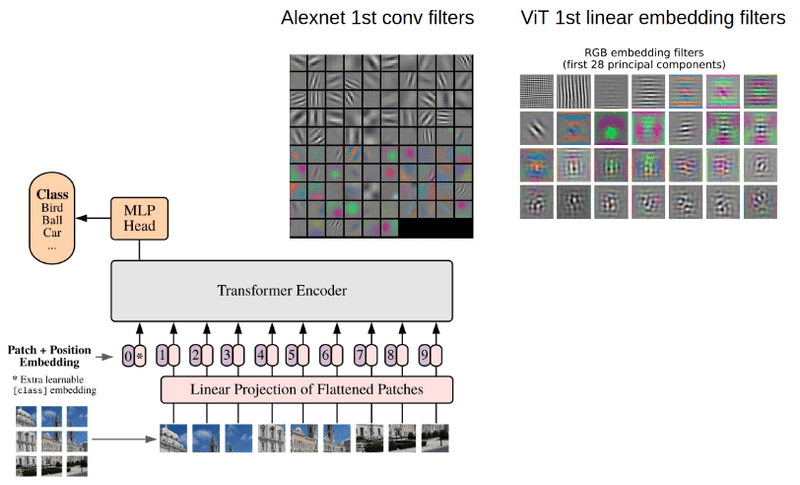

The Vision Transformer (ViT) is a state-of-the-art deep learning model for image recognition, introduced in 2020 by Dosovitskiy et al. Unlike traditional Convolutional Neural Networks (CNNs), ViT uses a transformer architecture, which was originally developed for natural language processing tasks.

The transformer architecture consists of several layers of self-attention and feedforward networks. In the self-attention layer, the input sequence is mapped to a set of queries, keys, and values, which are then used to compute a weighted sum of the values based on their relevance to each query. This allows the model to attend to different parts of the input sequence and capture long-range dependencies.

To apply the transformer to image data, ViT first converts each image into a sequence of patches, which are flattened and passed through an embedding layer to obtain a sequence of feature vectors. These feature vectors are then fed into the transformer layers, which learn to attend to different patches and capture the spatial relationships between them.

To enable the model to perform classification tasks, ViT adds a classification head on top of the transformer output. The classification head consists of a global average pooling layer, which computes the mean of the transformer output along the sequence dimension, followed by a fully connected layer and a softmax activation function.

ViT has achieved state-of-the-art performance on several benchmark image recognition datasets, including ImageNet and CIFAR-100. It has also been shown to generalize well to unseen data and outperform CNNs with a comparable number of parameters. However, ViT requires more computational resources than CNNs, especially for large-scale datasets, and may be less interpretable due to its complex attention mechanism.

In [1]:
!nvidia-smi

Fri Apr  7 18:33:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
# Importing all the required libraries
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 13.6 MB/s eta 0:00:0000:0100:01


In [3]:
# General parameters for testing
epochs = 15
pic_size = 240
np.random.seed(101)
tf.random.set_seed(101)

In [4]:
folder_path = "../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
no_images = os.listdir(folder_path + '/no/')
yes_images = os.listdir(folder_path + '/yes/')
dataset=[]
lab=[]

for image_name in no_images:
    image=cv2.imread(folder_path + '/no/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)
    
for image_name in yes_images:
    image=cv2.imread(folder_path + '/yes/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [5]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(253, 240, 240, 3) (253,)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

In [7]:
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path + "/" + state + "/" + os.listdir(folder_path + "/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()

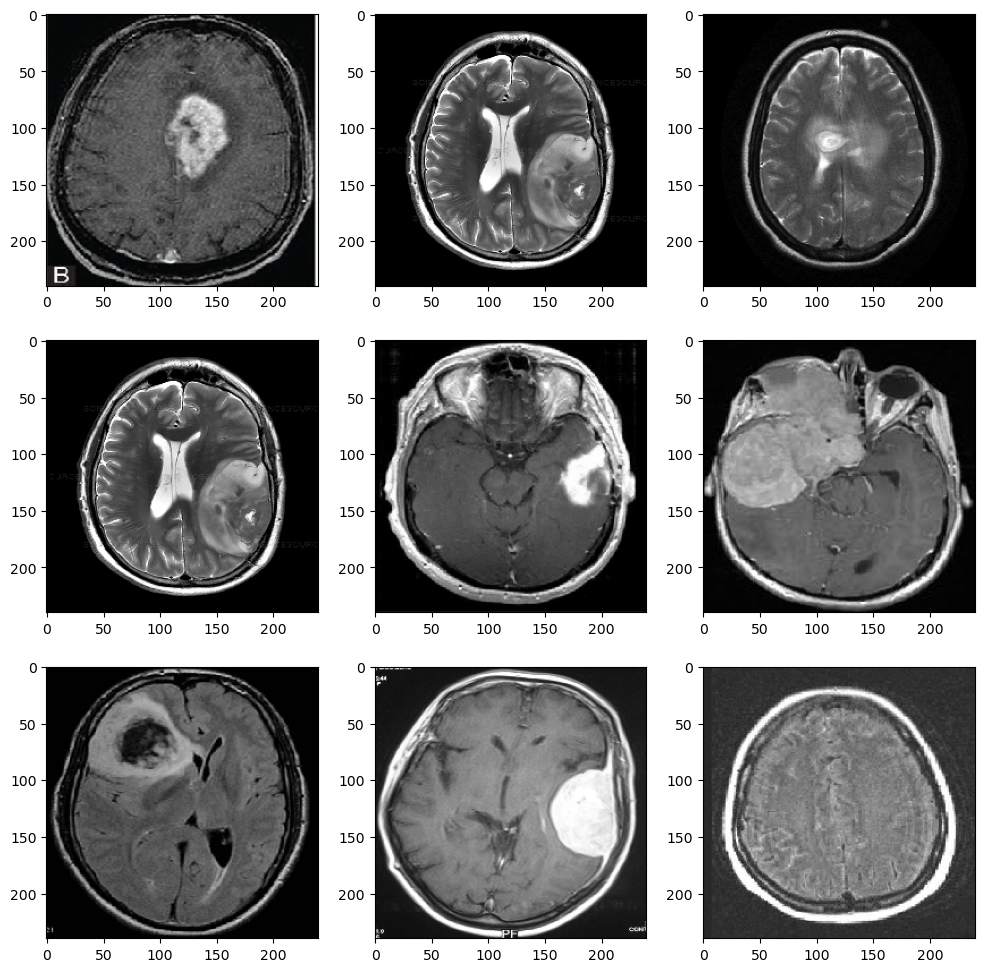

In [8]:
plot_state('yes')

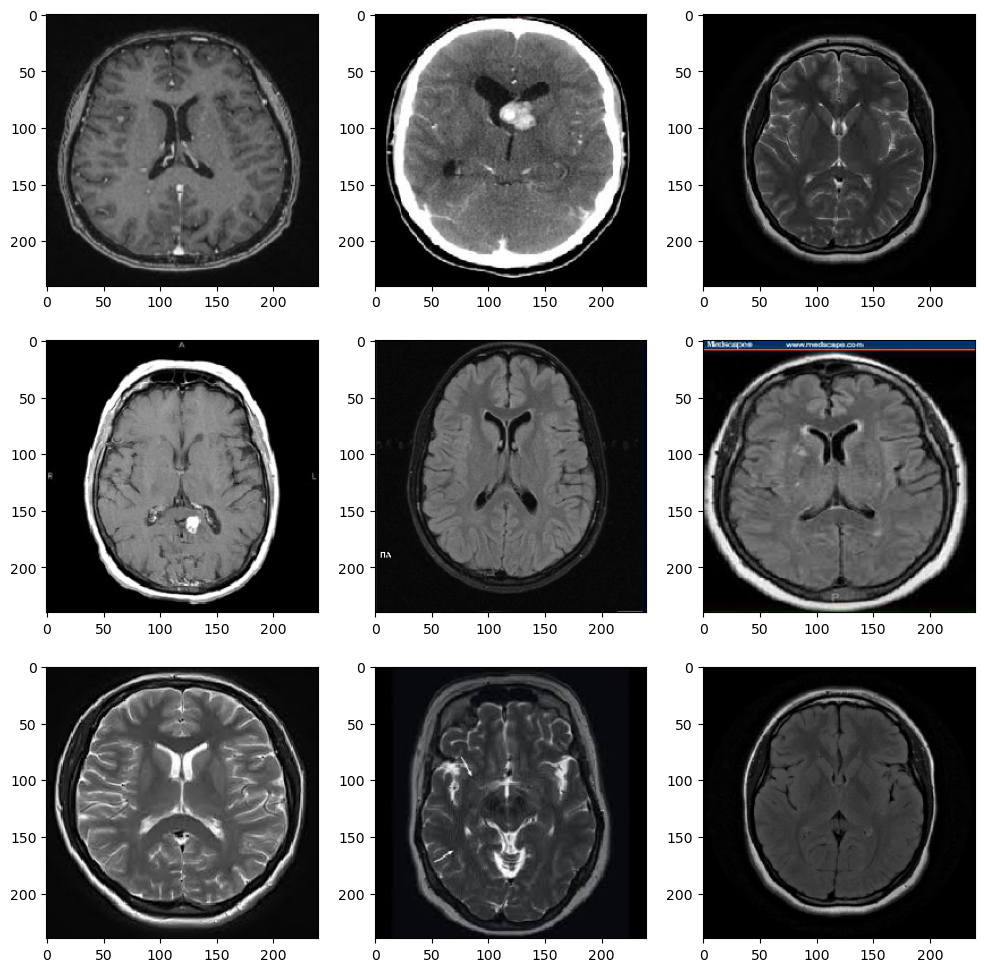

In [9]:
plot_state("no")

## CNNs

In [10]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 119, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 64)                4

In [13]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.294871794871795, 1: 0.8145161290322581}

In [14]:
history = model.fit(x_train,y_train,epochs = 100, class_weight=class_weights, validation_data=(x_test, y_test),verbose=1)

Epoch 1/100
7/7 [==============================] - 9s 93ms/step - loss: 38.8361 - accuracy: 0.5396 - val_loss: 6.1986 - val_accuracy: 0.6078
Epoch 2/100
7/7 [==============================] - 0s 21ms/step - loss: 5.9599 - accuracy: 0.6188 - val_loss: 5.6029 - val_accuracy: 0.6078
Epoch 3/100
7/7 [==============================] - 0s 21ms/step - loss: 5.4177 - accuracy: 0.6139 - val_loss: 5.1514 - val_accuracy: 0.6078
Epoch 4/100
7/7 [==============================] - 0s 20ms/step - loss: 5.0290 - accuracy: 0.6139 - val_loss: 4.8681 - val_accuracy: 0.6078
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 5.2811 - accuracy: 0.5842 - val_loss: 4.7147 - val_accuracy: 0.6078
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 4.6527 - accuracy: 0.6139 - val_loss: 4.5553 - val_accuracy: 0.6078
Epoch 7/100
7/7 [==============================] - 0s 19ms/step - loss: 4.5068 - accuracy: 0.6139 - val_loss: 4.4338 - val_accuracy: 0.6078
Epoch 8/100
7/7 [==

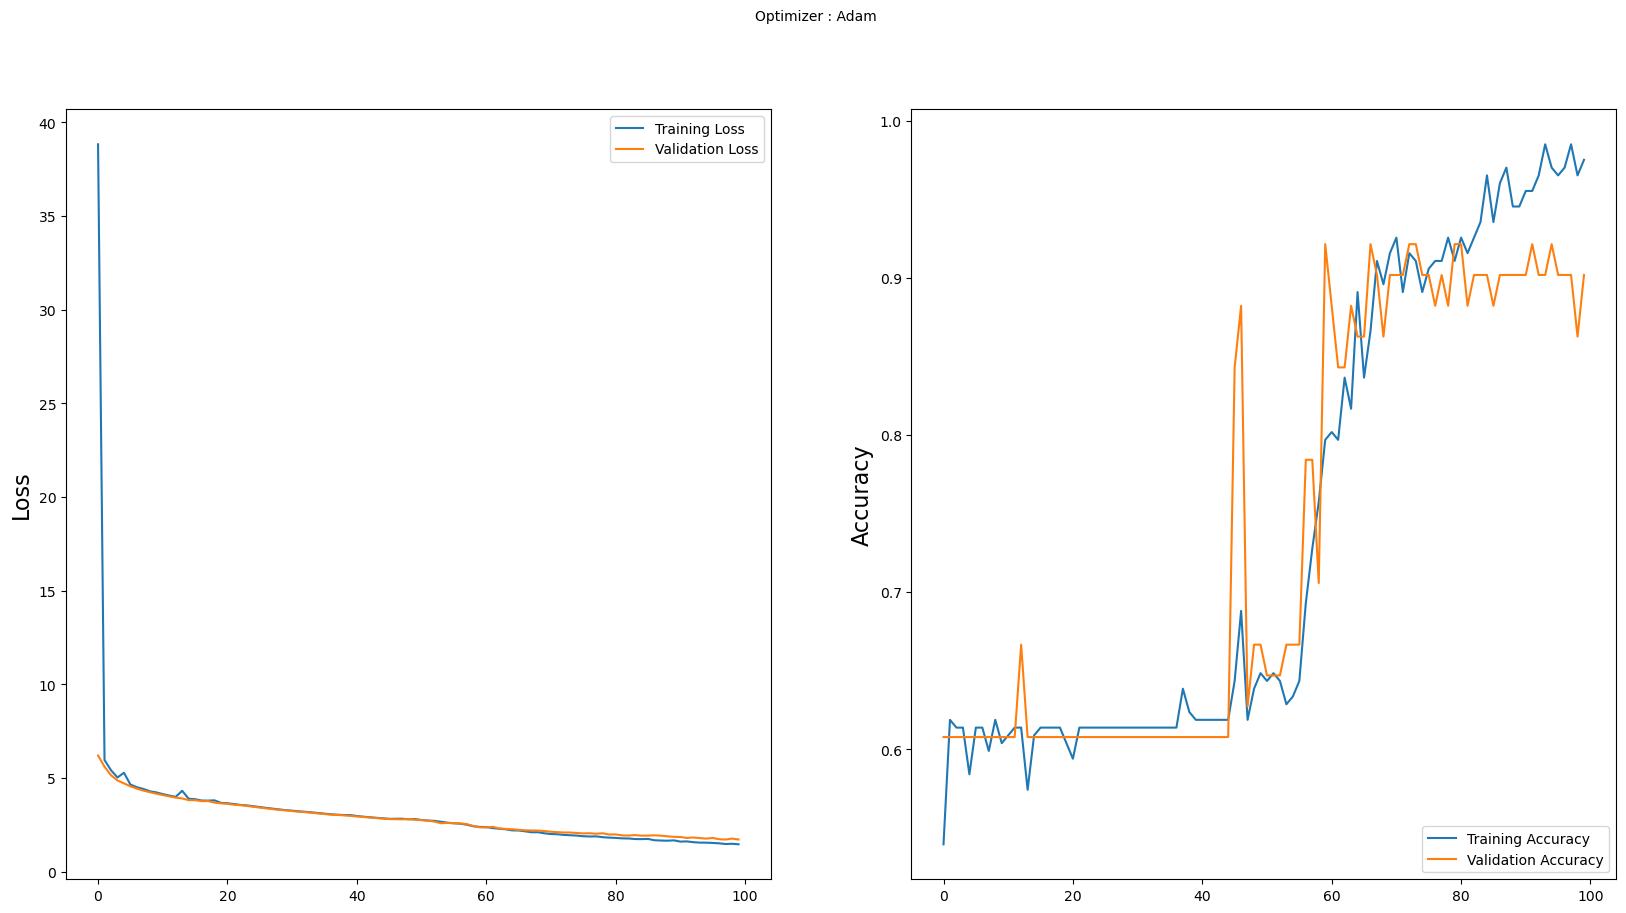

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
results = model.evaluate(x_test, y_test)
print('The current model achieved an accuracy of {}%!'.format(round(results[1]*100,2)))

2/2 [==============================] - 0s 9ms/step - loss: 1.7163 - accuracy: 0.9020
The current model achieved an accuracy of 90.2%!


In [17]:
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 7ms/step


In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

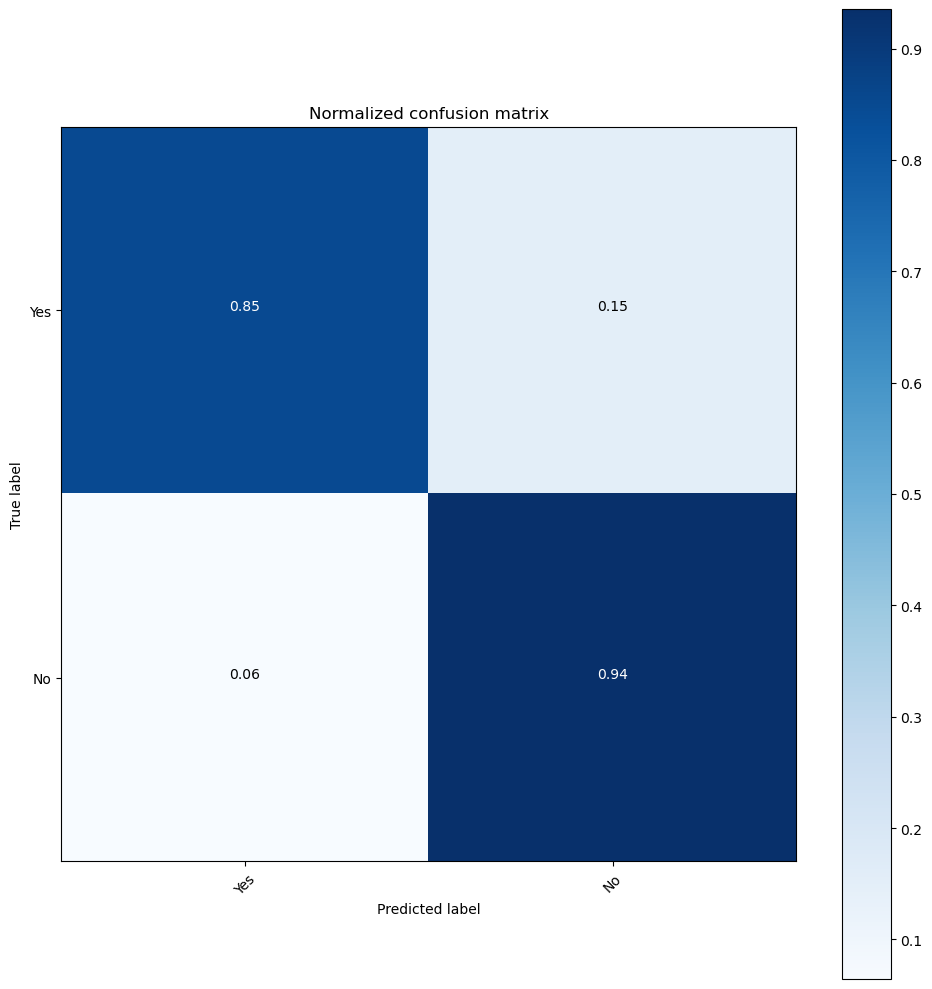

In [19]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()

# ViT

In [20]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 240  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

### Data Augmentation


In [21]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

### Multi-layer perceptron
MLP stands for Multilayer Perceptron, which is a type of feedforward neural network consisting of multiple layers of neurons, including an input layer, one or more hidden layers, and an output layer. MLPs are commonly used for a wide range of machine learning tasks, including classification, regression, and time series forecasting.

In the case of the Vision Transformer (ViT), an MLP is used as a part of the model's classification head. After passing the image patches through the transformer layers, the resulting feature vectors are concatenated and fed into an MLP that performs the final classification. This MLP takes the concatenated feature vectors as input and applies a series of nonlinear transformations to produce the final output logits.

The use of an MLP in the classification head allows the model to learn complex decision boundaries and perform nonlinear transformations on the feature vectors extracted by the transformer layers. This can be particularly important for image recognition tasks, where the input data can be highly complex and nonlinear.

In [22]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Patches as a layer
Patch creation in ViT refers to the process of dividing an input image into a grid of non-overlapping patches, which are then used as input to the transformer layers of the model. This approach allows the ViT model to process images of arbitrary sizes and aspect ratios, without requiring any explicit spatial pooling or downsampling operations.

The size of the patches in ViT is a hyperparameter that can be adjusted depending on the size of the input images and the desired spatial resolution of the model. Typically, patches of size 16x16 or 32x32 pixels are used, although larger or smaller patch sizes can also be used depending on the application.

After the image is divided into patches, each patch is flattened into a 1D vector and passed through an embedding layer to obtain a fixed-size representation of the patch. The resulting sequence of patch embeddings is then fed into the transformer layers of the ViT model, which learn to attend to different patches and capture the spatial relationships between them.

One advantage of patch-based approaches like ViT is that they allow the model to process images of arbitrary sizes and aspect ratios without requiring any explicit spatial pooling or downsampling operations. This can be particularly useful in applications where the input images vary in size and resolution, such as in medical imaging or remote sensing.

However, one potential limitation of patch-based approaches is that they may not capture fine-grained spatial details as well as traditional convolutional neural networks (CNNs), which are specifically designed to learn local and translation-invariant features. Nonetheless, the state-of-the-art performance of ViT on several benchmark image recognition datasets suggests that patch-based approaches can be highly effective for a wide range of computer vision tasks.

In [23]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 240 X 240
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


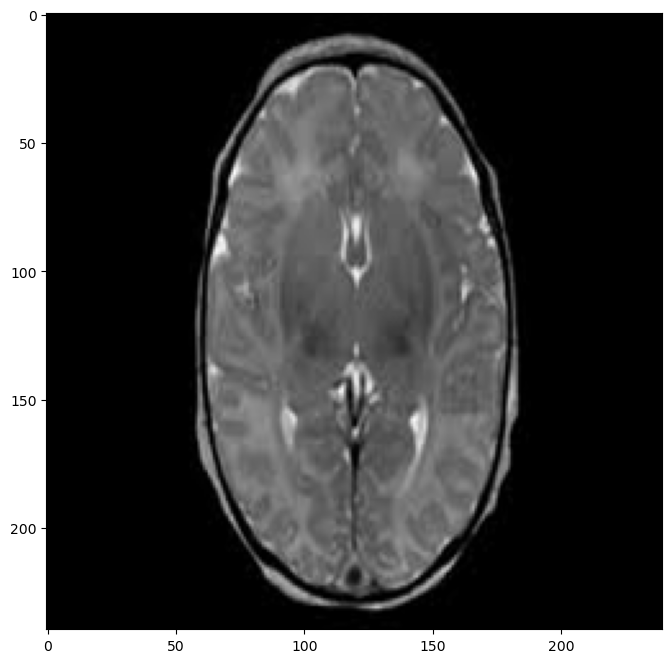

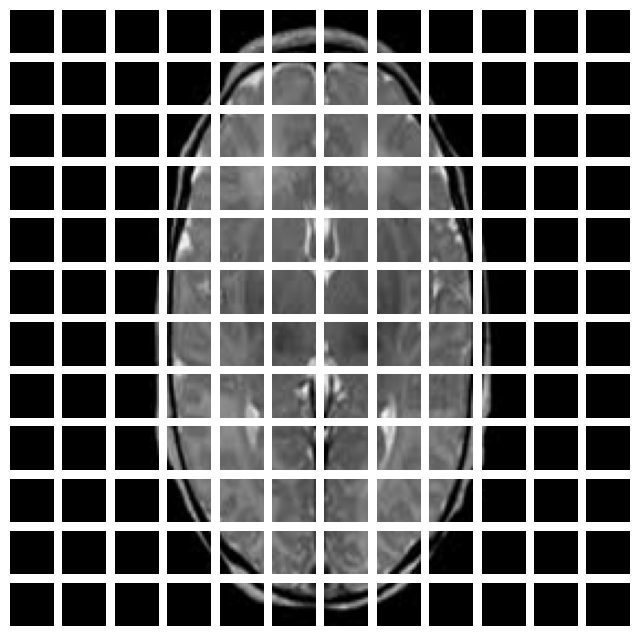

In [24]:
plt.figure(figsize=(8, 8))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Creating the Patch Encoder
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [25]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Creating the ViT 
The ViT model is composed of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. This allows the model to attend to different parts of the input image and capture long-range dependencies between patches. The output of the Transformer blocks is a [batch_size, num_patches, projection_dim] tensor, which is then processed by a classifier head with a softmax activation function to produce the final class probabilities output.

In contrast to the technique described in the original ViT paper, which adds a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with the layers.Flatten() function and used as the image representation input to the classifier head. This approach is more efficient and simplifies the architecture of the model. However, in cases where the number of patches and the projection dimensions are large, the layers.GlobalAveragePooling1D layer can be used instead to aggregate the outputs of the Transformer block. This can help reduce the number of parameters in the model and improve its generalization performance.

In [26]:
def create_vit_classifier():
    inputs = layers.Input(shape=(240, 240, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [27]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [28]:
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 23s 23s/step - loss: 1.4762 - accuracy: 0.5446 - top-5-accuracy: 1.0000 - val_loss: 9.9692 - val_accuracy: 0.4314 - val_top-5-accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 8.3753 - accuracy: 0.4653 - top-5-accuracy: 1.0000 - val_loss: 17.8272 - val_accuracy: 0.6078 - val_top-5-accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 6s 6s/step - loss: 16.7191 - accuracy: 0.6139 - top-5-accuracy: 1.0000 - val_loss: 1.7149 - val_accuracy: 0.6275 - val_top-5-accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 3.6526 - accuracy: 0.6287 - top-5-accuracy: 1.0000 - val_loss: 5.8801 - val_accuracy: 0.3922 - val_top-5-accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 5.1537 - accuracy: 0.4208 - top-5-accuracy: 1.0000 - val_loss: 1.1755 - val_accuracy: 0.5686 - val_top-5-accuracy: 1.0000
Epoch 6/100
1/1 [===================

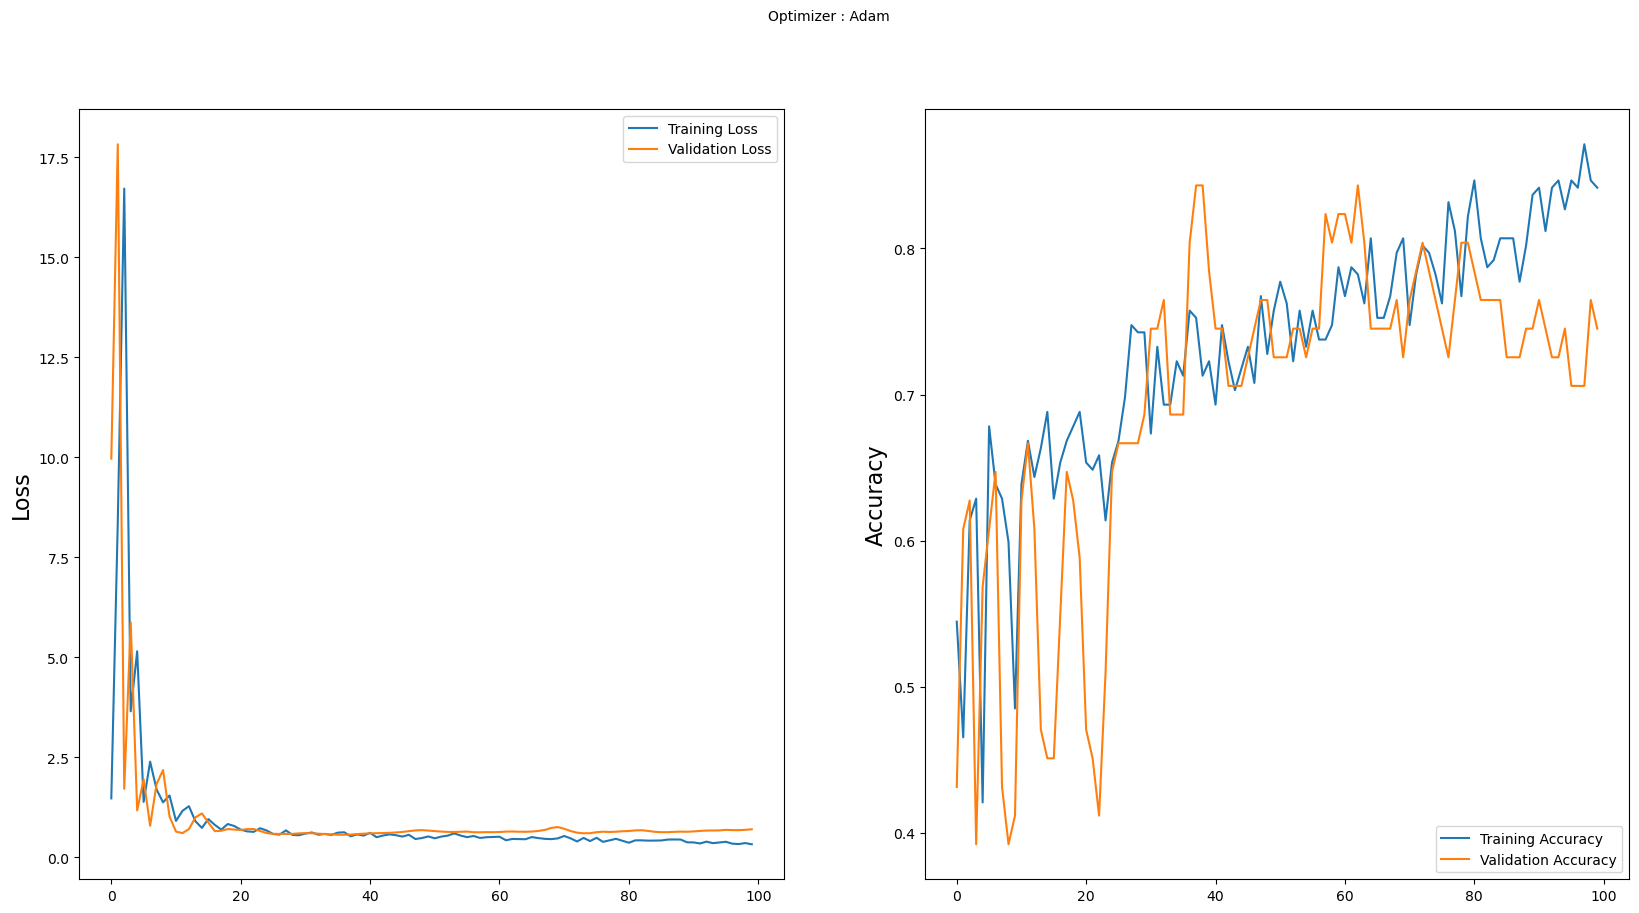

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [30]:
vit_predictions = vit_classifier.predict(x_test)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

2/2 [==============================] - 1s 38ms/step


<Figure size 640x480 with 0 Axes>

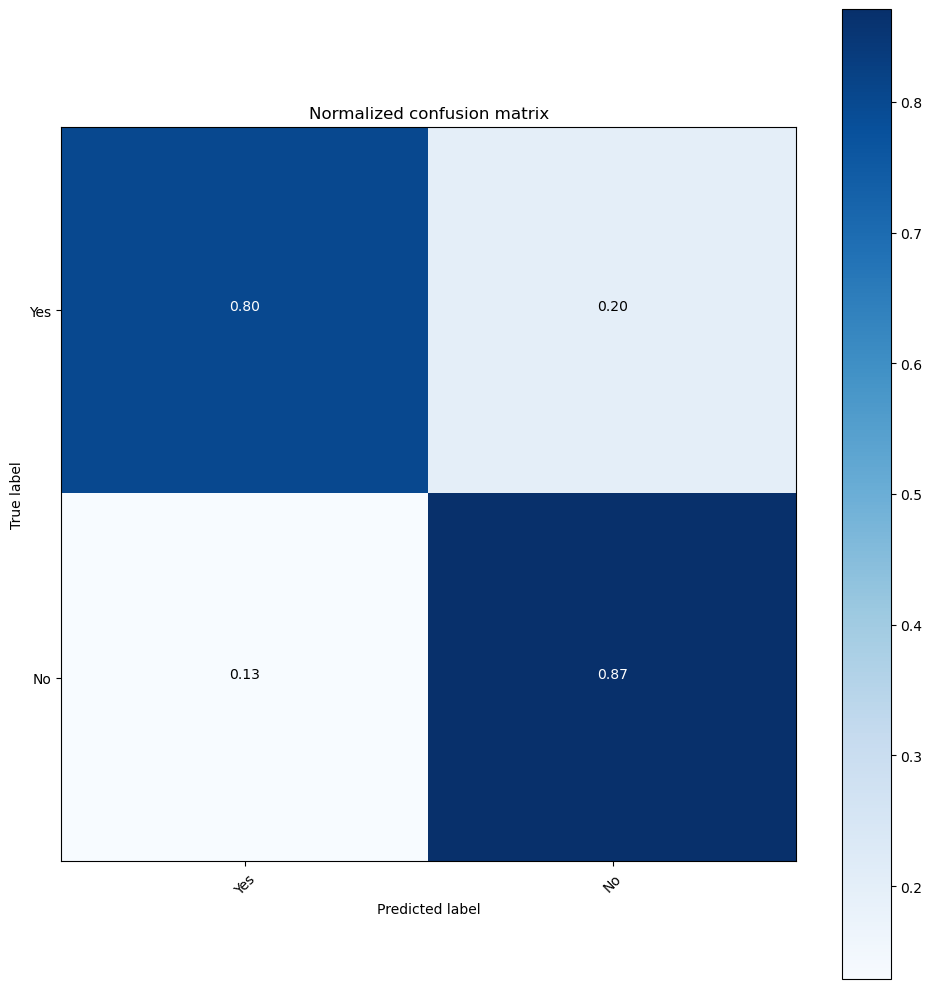

In [31]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()

## CNNs Vs ViT - Conclusion
CNNs have been the state-of-the-art for image recognition tasks for many years, and are known to be highly effective at capturing local and translation-invariant features in images. They are particularly good at identifying fine-grained details, such as edges and textures, and can learn to recognize complex patterns in large datasets. One of the main advantages of CNNs is that they require relatively few parameters compared to other deep learning models, which makes them faster to train and easier to deploy.

However, CNNs have some limitations. One of the main drawbacks is that they are sensitive to the size and aspect ratio of input images, and may require a lot of preprocessing and data augmentation to achieve good performance on datasets with varying image sizes. They are also not very good at modeling global dependencies between different parts of the image, which can make them less effective for certain types of tasks, such as object detection and segmentation.

ViTs, on the other hand, have shown very promising results for image recognition tasks, especially on datasets with large variations in image sizes and aspect ratios. They are highly effective at modeling long-range dependencies between different parts of the image, which makes them well-suited for tasks such as object detection and segmentation. They also require relatively few parameters compared to other state-of-the-art models, which makes them faster to train and easier to deploy.

However, ViTs also have some limitations. One of the main drawbacks is that they may not capture fine-grained spatial details as well as CNNs, which are specifically designed to learn local and translation-invariant features. They may also be less effective for tasks that require a lot of data augmentation, as the patches used as input to the model may not capture all the relevant details in the image. Additionally, ViTs may require more computational resources than CNNs, especially for larger image sizes and patch resolutions.